# France

Note that a few municipalities has 0 population due to WW1 and are not included in the turnout data.

In [34]:
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina'

## Fetch results

In [35]:
base_url = ('https://www.interieur.gouv.fr/Elections/Les-resultats/'
            'Europeennes/elecresult__ER2014/(path)/ER2014')

In [177]:
base_url

'https://www.interieur.gouv.fr/Elections/Les-resultats/Europeennes/elecresult__ER2014/(path)/ER2014'

In [36]:
def get_departments():
    url = f'{base_url}/index.html'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    options = html.select('#listeDpt option')[1:]
    return [x['value'] for x in options]

In [37]:
def get_municipality_letter_lists(department_url):
    url = f'{base_url}/{department_url}'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    letters = html.select('.pub-index-communes a')
    return [x['href'].split('../')[-1] for x in letters]

In [38]:
def get_municipalities(letter_url):
    url = f'{base_url}/{letter_url}'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    municipalities = html.select('.tableau-communes a')
    return [x['href'].split('../')[-1] for x in municipalities]

In [39]:
def get_municipality(municipality_url):
    url = f'{base_url}/{municipality_url}'
    df = pd.read_html(url, index_col=0, encoding='utf8')[1]
    df['id'] = municipality_url.split('/')[-1].split('.')[0]
    return df

In [ ]:
%%time
municipalities = []

for department in get_departments():
    print(department)
    for letter_list in get_municipality_letter_lists(department):
        for municipality in get_municipalities(letter_list):
            data = get_municipality(municipality)
            municipalities.append(data)

In [41]:
# Special case for Paris
paris = []
for arrond in get_municipality_letter_lists('07/011/075/index.html'):
    data = get_municipality(arrond)
    paris.append(data)

In [42]:
paris = pd.concat(paris)

In [259]:
df = pd.concat(municipalities)

In [260]:
inscrits = df.loc['Inscrits', ['Nombre', 'id']].set_index('id', drop=True)
votants = df.loc['Votants', ['Nombre', 'id']].set_index('id', drop=True)
df = votants.merge(inscrits, left_index=True, right_index=True)
df.columns = ['voted', 'registered']
df.voted = df.voted.astype(str).str.replace(' ', '').astype(int)
df.registered = df.registered.astype(str).str.replace(' ', '').astype(int)
df['turnout'] = df.voted / df.registered * 100
df = df.reset_index()
df.id = df.id.apply(lambda x: f'{x[:3]}{x[4:]}' if x.startswith('97') or
                              x.startswith('98') else x[1:])
#df.id = df.id.str[1:]

In [106]:
inscrits = paris.loc['Inscrits', ['Nombre', 'id']].set_index('id', drop=True)
votants = paris.loc['Votants', ['Nombre', 'id']].set_index('id', drop=True)
paris = votants.merge(inscrits, left_index=True, right_index=True)
paris.columns = ['voted', 'registered']
paris.voted = paris.voted.astype(str).str.replace(' ', '').astype(int)
paris.registered = paris.registered.astype(str).str.replace(' ', '').astype(int)
paris['turnout'] = paris.voted / paris.registered * 100
paris = paris.reset_index()
paris.id = paris.id.str[1:]

In [261]:
df = pd.concat([df, paris], sort=True)

In [272]:
df.to_csv('../../data/raw/fra.csv', index=False)

## Merge

In [284]:
geo = gpd.read_file('../../data/shapefiles/fra/communes-plus-20140630-100m.shp')

In [275]:
# Paris
df.id = df.id.str.replace('75056AR', '751')

# Marseille
df.id = df.id.str.replace('13055AR', '132')

# Lyon
df.id = df.id.str.replace('69123AR0', '6938')

In [285]:
geo = geo.merge(df, left_on='insee', right_on='id', how='left')

## Export

In [286]:
geo = geo[['nom', 'turnout', 'geometry']]
geo = geo.rename(columns={'nom': 'name'})

In [287]:
geo['country'] = 'fra'

In [288]:
geo.to_file('../../data/processed/fra')

## Visualize

/Users/robinlinderborg/.local/share/virtualenvs/eu-election-turnout-IRqnHkiA/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


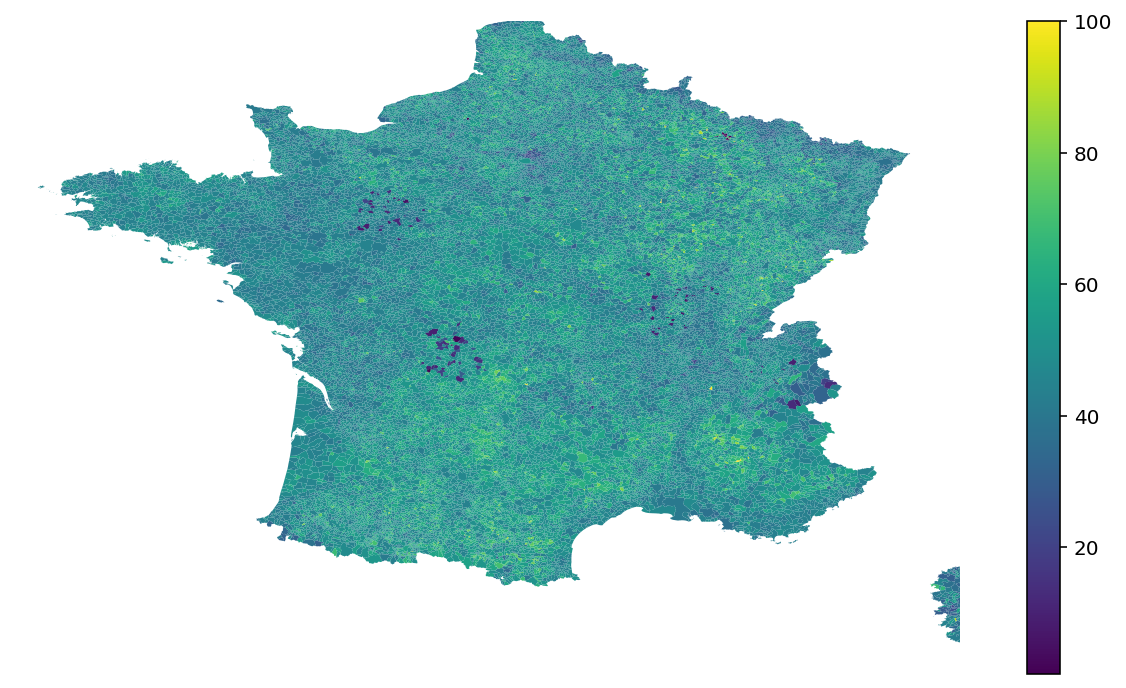

In [134]:
ax = geo.plot(figsize=(12, 6), column='turnout', legend=True);
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_xlim(-5.5, 9)
ax.set_ylim(41, 51)
ax.set_axis_off();